Version 1.0.1

# Check your versions

In [1]:
import numpy as np
import pandas as pd 
import sklearn
import scipy.sparse 
import lightgbm 

for p in [np, pd, scipy, sklearn, lightgbm]:
    print (p.__name__, p.__version__)

numpy 1.14.3
pandas 0.23.0
scipy 1.1.0
sklearn 0.19.0
lightgbm 2.0.6


**Important!** There is a huge chance that the assignment will be impossible to pass if the versions of `lighgbm` and `scikit-learn` are wrong. The versions being tested:

    numpy 1.13.1
    pandas 0.20.3
    scipy 0.19.1
    sklearn 0.19.0
    ligthgbm 2.0.6
    

To install an older version of `lighgbm` you may use the following command:
```
pip uninstall lightgbm
pip install lightgbm==2.0.6
```

# Ensembling

In this programming assignment you are asked to implement two ensembling schemes: simple linear mix and stacking.  
このプログラミング課題では、単純な線形ミックスとスタッキングの2つのアンサンブルスキームを実装するように求められます。

We will spend several cells to load data and create feature matrix, you can scroll down this part or try to understand what's happening.  
データをロードして特徴量マトリックスを作成するために複数のセルを使用し、このパートをスクロールダウンしてもよいし、何が起きているのかを理解したりできます。

In [3]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
%matplotlib inline 

pd.set_option('display.max_rows', 600) # 600行まで表示
pd.set_option('display.max_columns', 50) # 50行まで表示

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

from itertools import product


def downcast_dtypes(df):
    # 64bit→32bitに変換する関数
    '''
        Changes column types in the dataframe:
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

# Load data subset

Let's load the data from the hard drive first.

In [4]:
sales = pd.read_csv('../readonly/final_project_data/sales_train.csv.gz')
shops = pd.read_csv('../readonly/final_project_data/shops.csv')
items = pd.read_csv('../readonly/final_project_data/items.csv')
item_cats = pd.read_csv('../readonly/final_project_data/item_categories.csv')

And use only 3 shops for simplicity.

In [33]:
sales = sales[sales['shop_id'].isin([26, 27, 28])]
display(sales.shape)
display(sales[0:2])

(301510, 6)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
15036,05.01.2013,0,28,7738,199.0,1.0
15037,07.01.2013,0,28,7738,199.0,1.0


# Get a feature matrix

We now need to prepare the features. This part is all implemented for you.  
特徴量を準備する必要がある。このパートはすべてあなた用に実装されています。

In [100]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
# 毎月、その月のすべてのショップ/商品の組み合わせからグリッドを作成します
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe（grid→データフレーム変換）
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

#確認用コード----------------------------------------------
display('gridの中身--------------------------------------')
display(len(grid))
display(grid[0:2])# 月単位で、shop, item, block_numの配列を作成
# ----------------------------------------------

# Groupby data to get shop-item-month aggregates（店舗×商品×月別の売上数量の集計を取得するためにsalesデータをgroupbyする）
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})

#確認用コード----------------------------------------------
display('gbの中身1--------------------------------------')
display(len(gb))
display(gb[0:2])
# ----------------------------------------------

# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 

#確認用コード----------------------------------------------
display('gbの中身2--------------------------------------')
display(len(gb))
display(gb[0:2])# 月単位で、shop, item, block_num, 売上数量のデータフレームを作成
# ----------------------------------------------

# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

#確認用コード----------------------------------------------
display('all_dataの中身--------------------------------------')
display(len(all_data))
display(all_data[0:2])# 月単位で、shop, item, block_num, 売上数量のデータフレームを作成
# ----------------------------------------------

# Same as above but with shop-month aggregates（店舗×月別の売上数量の集計）
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates（商品×月別の売上数量の集計）
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

#確認用コード----------------------------------------------
display('all_dataの中身2--------------------------------------')
display(len(all_data))
display(all_data[0:2])# 月単位で、shop, item, block_num, 売上数量のデータフレームを作成
# ----------------------------------------------

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

'gridの中身--------------------------------------'

278619

,shop_id,item_id,date_block_num
0,28,7738,0
1,28,7737,0


E:\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:4658: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


'gbの中身1--------------------------------------'

145463

,shop_id,item_id,date_block_num,item_cnt_day
,,,,target
0,26,27,0,1.0
1,26,27,10,1.0


'gbの中身2--------------------------------------'

145463

,shop_id,item_id,date_block_num,target
0,26,27,0,1.0
1,26,27,10,1.0


'all_dataの中身--------------------------------------'

278619

,shop_id,item_id,date_block_num,target
0,28,7738,0,4.0
1,28,7737,0,10.0


'all_dataの中身2--------------------------------------'

278619

,shop_id,item_id,date_block_num,target,target_shop,target_item
0,28,7738,0,4.0,7057.0,11.0
1,28,7737,0,10.0,7057.0,16.0


After creating a grid, we can calculate some features. We will use lags from [1, 2, 3, 4, 5, 12] months ago.  
グリッドを作成したら、いくつかの特徴量を計算できます。私たちは[1,2,3,4,5,12]ヶ月前のラグを使用します。

In [101]:
# List of columns that we will use to create lags(ラグの作成に使用する列のリスト)
cols_to_rename = list(all_data.columns.difference(index_cols)) # index_cols = ['shop_id', 'item_id', 'date_block_num'] 以外のcolumnsを取得
display(cols_to_rename)

shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    #ラグ列をJOINするためのコピーを作成
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    # date_block_numの値のみ変更
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift #もともとn期のデータをN+t期のデータにjoinする仕組み
    
    # 列名のみ変更
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    # JOIN
    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

#確認用コード----------------------------------------------
display('all_dataの中身--------------------------------------')
display(len(all_data))
display(all_data[0:2])# (6種類のラグの追加)
# ----------------------------------------------

# List of all lagged features(全てのラグ特徴量のリスト 'target_lag_1'～'target_shop_lag_12'の18要素)
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 

# We will drop these at fitting stage（fittingのステージにおいて、これらをドロップするために定義 → ['target_item', 'target_shop', 'target', 'date_block_num']）
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Category for each item(商品カテゴリのマッピング)
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates() #item_idとitem_category_idの重複を排除した、組み合わせ配列
#確認用コード----------------------------------------------
display('item_category_mappingの中身--------------------------------------')
display(item_category_mapping[0:2])
display()
# ----------------------------------------------

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
#確認用コード----------------------------------------------
display('all_dataの中身--------------------------------------')
display(len(all_data))
display(all_data[0:2])# item_category_idの追加
display(all_data[-3:-1])# item_category_idの追加
# ----------------------------------------------

gc.collect();

['target', 'target_item', 'target_shop']

'all_dataの中身--------------------------------------'

157950

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12
120669,28,10994,12,1.0,6949.0,1.0,0.0,1.0,8499.0,0.0,1.0,6454.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120670,28,10992,12,3.0,6949.0,4.0,3.0,7.0,8499.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7521.0,0.0,0.0,0.0


'item_category_mappingの中身--------------------------------------'

,item_id,item_category_id
0,0,40
1,1,76


'all_dataの中身--------------------------------------'

157950

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,28,10994,12,1.0,6949.0,1.0,0.0,1.0,8499.0,0.0,1.0,6454.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,28,10992,12,3.0,6949.0,4.0,3.0,7.0,8499.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7521.0,0.0,0.0,0.0,37


,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
157947,26,21976,33,0.0,1409.0,2.0,1.0,1.0,1553.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,953.0,0.0,0.0,0.0,0.0,0.0,0.0,61
157948,26,21881,33,0.0,1409.0,2.0,0.0,2.0,1553.0,0.0,3.0,1189.0,0.0,4.0,1007.0,0.0,2.0,953.0,0.0,8.0,1358.0,0.0,0.0,0.0,40


To this end, we've created a feature matrix. It is stored in `all_data` variable. Take a look:

In [102]:
all_data.head(5)

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,28,10994,12,1.0,6949.0,1.0,0.0,1.0,8499.0,0.0,1.0,6454.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,28,10992,12,3.0,6949.0,4.0,3.0,7.0,8499.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7521.0,0.0,0.0,0.0,37
2,28,10991,12,1.0,6949.0,5.0,1.0,3.0,8499.0,0.0,0.0,0.0,0.0,1.0,5609.0,0.0,2.0,6753.0,2.0,4.0,7521.0,0.0,0.0,0.0,40
3,28,10988,12,1.0,6949.0,2.0,2.0,5.0,8499.0,4.0,5.0,6454.0,5.0,6.0,5609.0,0.0,2.0,6753.0,0.0,0.0,0.0,0.0,0.0,0.0,40
4,28,11002,12,1.0,6949.0,1.0,0.0,1.0,8499.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40


# Train/test split

For a sake of the programming assignment, let's artificially split the data into train and test. We will treat last month data as the test set.

In [103]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
# `date_block_num`を特徴量として使うことはできませんが、データセットを分割する必要があるので` date_block_num`を保存してください
dates = all_data['date_block_num']

last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 33


In [107]:
dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]
display(dates_train[0:2])

#
X_train = all_data.loc[dates <  last_block].drop(to_drop_cols, axis=1) #'date_block_num'列の値<33のデータのみ取得＆'不要列の削除
X_test =  all_data.loc[dates == last_block].drop(to_drop_cols, axis=1) #'date_block_num'列の値=33のデータのみ取得＆'不要列の削除
display(X_train[0:2])

y_train = all_data.loc[dates <  last_block, 'target'].values #月×店舗×商品の売上数量の取得（教師データ）
y_test =  all_data.loc[dates == last_block, 'target'].values #月×店舗×商品の売上数量の取得（正解データ）
display(y_train[0:5])

0    12
1    12
Name: date_block_num, dtype: int32

,shop_id,item_id,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,28,10994,0.0,1.0,8499.0,0.0,1.0,6454.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,28,10992,3.0,7.0,8499.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7521.0,0.0,0.0,0.0,37


array([1., 3., 1., 1., 1.], dtype=float32)

# First level models 

You need to implement a basic stacking scheme. We have a time component here, so we will use ***scheme f)*** from the reading material. Recall, that we always use first level models to build two datasets: test meta-features and 2-nd level train-metafetures. Let's see how we get test meta-features first.

基本的なスタッキングスキームを実装する必要があります。ここには時間的な要素がありますので、読書資料から*** scheme f）*** を使用します。私たちは常に2つのデータセットを構築する第1レベルのモデル（テスト用メタ特徴量）と、第2レベルの学習用のメタ特徴量を使うことを思い出してください。最初にテスト用のメタ特徴量をどのように取得するかを見てみましょう。

### Test meta-features

Firtts, we will run *linear regression* on numeric columns and get predictions for the last month.  
最初に、数字列で*線形回帰*を実行し、先月の予測を取得します

In [108]:
lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values)

print('Test R-squared for linreg is %f' % r2_score(y_test, pred_lr))

Test R-squared for linreg is 0.743180


And the we run *LightGBM*.

In [109]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test)

print('Test R-squared for LightGBM is %f' % r2_score(y_test, pred_lgb))

Test R-squared for LightGBM is 0.738391


Finally, concatenate test predictions to get test meta-features.  
最後に、テスト予測を連結してテストメタ特徴量を取得します。

In [113]:
X_test_level2 = np.c_[pred_lr, pred_lgb]
display(X_test_level2.shape)
display(X_test_level2)

(3354, 2)

array([[13.45896153, 13.37831474],
       [ 3.18599444,  2.55590212],
       [ 2.5028209 ,  1.52356814],
       ...,
       [ 0.69860529,  0.41663964],
       [ 0.12072911,  0.34056468],
       [ 0.1755516 ,  0.32987826]])

### Train meta-features

**Now it is your turn to write the code**. You need to implement ***scheme f)*** from the reading material. Here, we will use duration **T** equal to month and **M=15**.  
** 今度はコードを書いてください。**  読書資料から *** scheme f）*** を実装する必要があります。 ここでは、期間 ** T ** を月に、 ** M = 15 ** を使用します。

That is, you need to get predictions (meta-features) from *linear regression* and *LightGBM* for months 27, 28, 29, 30, 31, 32. Use the same parameters as in above models.  
つまり、27、28、29、30、31、32ヶ月間 *線形回帰* と * LightGBM * から予測（メタ機能）を取得する必要があります。上記のモデルと同じパラメータを使用します。

In [114]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

In [115]:
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32]:
    
    print(cur_block_num)
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      
    
    #  YOUR CODE GOES HERE
    X_train = all_data.loc[dates <  cur_block_num].drop(to_drop_cols, axis=1)
    X_test =  all_data.loc[dates == cur_block_num].drop(to_drop_cols, axis=1)

    y_train = all_data.loc[dates <  cur_block_num, 'target'].values
    
    
    lr.fit(X_train.values, y_train)
    pred_lr = lr.predict(X_test.values)
    model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
    pred_lgb = model.predict(X_test)
    
    indexes = dates_train_level2.index[dates_train_level2 == cur_block_num]
    
    for i in range(pred_lgb.shape[0]):
        X_train_level2[indexes[i] - 120192 ] = [pred_lr[i], pred_lgb[i]] 
    
# Sanity check
assert np.all(np.isclose(X_train_level2.mean(axis=0), [ 1.50148988,  1.38811989]))

27
28
29
30
31
32


Remember, the ensembles work best, when first level models are diverse. We can qualitatively analyze the diversity by examinig *scatter plot* between the two metafeatures. Plot the scatter plot below.   
最初のレベルのモデルが多様な場合、アンサンブルが最も効果的です。 我々は、2つのメタファクタ間の散布図を調べることによって、多様性を定性的に分析することができる。 以下の散布図をプロットします。

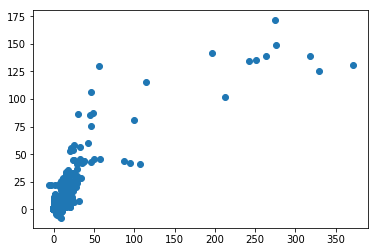

In [116]:
# YOUR CODE GOES HERE
import matplotlib.pyplot as plt

x = X_train_level2[:,0]
y = X_train_level2[:,1]
plt.scatter(x, y)
plt.show()

# Ensembling

Now, when the meta-features are created, we can ensemble our first level models.  
今、メタフィーチャーが作成されると、最初のレベルのモデルをアンサンブルすることができます。

### Simple convex mix

Let's start with simple linear convex mix:

$$
mix= \alpha\cdot\text{linreg_prediction}+(1-\alpha)\cdot\text{lgb_prediction}
$$

We need to find an optimal $\alpha$. And it is very easy, as it is feasible to do grid search. Next, find the optimal $\alpha$ out of `alphas_to_try` array. Remember, that you need to use train meta-features (not test) when searching for $\alpha$.   
我々は最適なαを見つける必要がある。 グリッド検索が可能なので、非常に簡単です。 次に、alphas_to_try配列から最適なαを見つける。 αを検索するときは、学習のメタ特徴量（テストではない）を使用する必要があることに注意してください。

In [118]:
alphas_to_try = np.linspace(0, 1, 1001)

# YOUR CODE GOES HERE
best_alpha = -1 # YOUR CODE GOES HERE
r2_train_simple_mix = -1 # YOUR CODE GOES HERE

# YOUR CODE GOES HERE
for current_alpha in alphas_to_try:
    mix = current_alpha * X_train_level2[:,0] + (1 - current_alpha) * X_train_level2[:,1]
    current_r2 = r2_score(y_train_level2, mix)
    if(current_r2 > r2_train_simple_mix):
        r2_train_simple_mix = current_r2
        best_alpha = current_alpha

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))

Best alpha: 0.765000; Corresponding r2 score on train: 0.627255


Now use the $\alpha$ you've found to compute predictions for the test set 

In [119]:
test_preds =  best_alpha * X_test_level2[:,0] + (1 - best_alpha) * X_test_level2[:,1] # YOUR CODE GOES HERE
r2_test_simple_mix = r2_score(y_test, test_preds) # YOUR CODE GOES HERE

print('Test R-squared for simple mix is %f' % r2_test_simple_mix)

Test R-squared for simple mix is 0.781144


### Stacking

Now, we will try a more advanced ensembling technique. Fit a linear regression model to the meta-features. Use the same parameters as in the model above.  
さて、より高度なアンサンブル技術を試してみましょう。 線形回帰モデルをメタフィーチャに適合させる。 上記のモデルと同じパラメータを使用してください。

In [120]:
# YOUR CODE GOES HERE
lr.fit(X_train_level2, y_train_level2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Compute R-squared on the train and test sets.  
学習とテストセットでR-二乗を計算します。

In [122]:
train_preds = lr.predict(X_train_level2) # YOUR CODE GOES HERE
r2_train_stacking = r2_score(y_train_level2, train_preds) # YOUR CODE GOES HERE

test_preds = lr.predict(X_test_level2) # YOUR CODE GOES HERE
r2_test_stacking = r2_score(y_test, test_preds)# YOUR CODE GOES HERE

print('Train R-squared for stacking is %f' % r2_train_stacking)
print('Test  R-squared for stacking is %f' % r2_test_stacking)

Train R-squared for stacking is 0.632176
Test  R-squared for stacking is 0.771297


Interesting, that the score turned out to be lower than in previous method. Although the model is very simple (just 3 parameters) and, in fact, mixes predictions linearly, it looks like it managed to overfit. **Examine and compare** train and test scores for the two methods.   
興味深いことに、スコアは以前の方法よりも低いことが判明した。 モデルは非常にシンプルで（わずか3パラメータ）、実際には予測を線形にミックスしていますが、過密に管理されているように見えます。 2つの方法の学習とテストのスコアを調べて比較します。

And of course this particular case does not mean simple mix is always better than stacking.  
もちろん、この特殊なケースは、単純なミックスが常にスタッキングより優れていることを意味するものではありません。

We all done! Submit everything we need to the grader now.

In [123]:
from grader import Grader
grader = Grader()

grader.submit_tag('best_alpha', best_alpha)

grader.submit_tag('r2_train_simple_mix', r2_train_simple_mix)
grader.submit_tag('r2_test_simple_mix',  r2_test_simple_mix)

grader.submit_tag('r2_train_stacking', r2_train_stacking)
grader.submit_tag('r2_test_stacking',  r2_test_stacking)

Current answer for task best_alpha is: 0.765
Current answer for task r2_train_simple_mix is: 0.6272550434461527
Current answer for task r2_test_simple_mix is: 0.7811441695790337
Current answer for task r2_train_stacking is: 0.6321755614590682
Current answer for task r2_test_stacking is: 0.7712971323422437


In [ ]:
STUDENT_EMAIL = # EMAIL HERE
STUDENT_TOKEN = # TOKEN HERE
grader.status()

In [ ]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)